#### init

In [145]:
import turicreate as tc
import numpy as np
import matplotlib.pyplot as plt

image_train_data = tc.SFrame('image_train_data')
image_test_data = tc.SFrame('image_test_data')

# Funcao de retornar Img pelo ID
def get_images_from_ids(query_result):
    return image_train_data.filter_by(query_result['reference_label'],'id')

#Funcao para gerar modelos
def train_data_label(label):
    data_l = image_train_data.filter_by(label, column_name='label')
    knn_model = tc.nearest_neighbors.create(data_l,
                                features=['deep_features'],
                                label='id')
    return knn_model

# Criar o modelo KNN
cat_knn_model = train_data_label(['cat'])
dog_knn_model = train_data_label(['dog'])
bird_knn_model = train_data_label(['bird'])
automobile_knn_model = train_data_label(['bird'])



Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

Starting brute force nearest neighbors model training.

Validating distance components.

Initializing model data.

Initializing distances.

Done.

# 1. Qual é a categoria menos comum nos dados de treinamento?

In [146]:
sketch = turicreate.Sketch(image_train_data['label'])
sketch


+------------------+-------+----------+
|       item       | value | is exact |
+------------------+-------+----------+
|      Length      |  2005 |   Yes    |
| # Missing Values |   0   |   Yes    |
| # unique values  |   4   |    No    |
+------------------+-------+----------+

Most frequent items:
+------------+-------+
|   value    | count |
+------------+-------+
|    cat     |  509  |
|    dog     |  509  |
| automobile |  509  |
|    bird    |  478  |
+------------+-------+


# 2. Das imagens abaixo, qual é a imagem rotulada como "gato" mais próxima nos dados de treinamento da primeira imagem nos dados de teste (image_test[0:1])?

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 9.286ms      |

| Done         |         | 100         | 55.354ms     |

+--------------+---------+-------------+--------------+

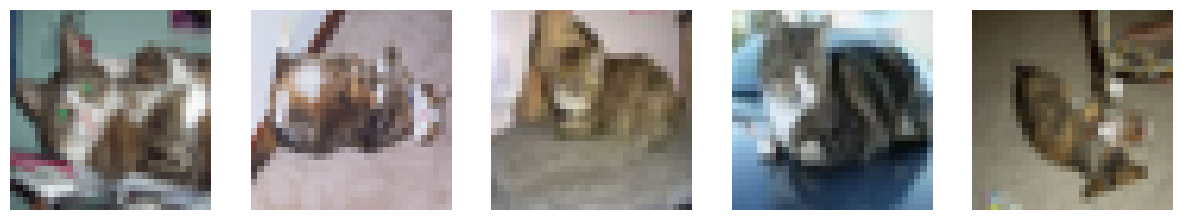

In [147]:
show_neighbors_cats = lambda i: get_images_from_ids(cat_knn_model.query(image_test_data[i:i+1]))['image']
# Plotar as primeiras 5 imagens retornadas
plt.figure(figsize=(15, 3))
for j, img in enumerate(show_neighbors_cats(0)[:5]):
    img = np.array(img.pixel_data)
    plt.subplot(1, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# 3. Das imagens abaixo, qual é a imagem rotulada como "cachorro" mais próxima nos dados de treinamento da primeira imagem nos dados de teste (image_test[0:1])?

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 10.904ms     |

| Done         |         | 100         | 54.913ms     |

+--------------+---------+-------------+--------------+

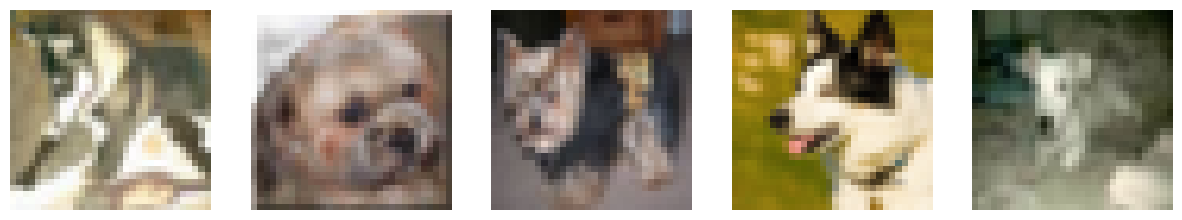

In [148]:
show_neighbors_dogs = lambda i: get_images_from_ids(dog_knn_model.query(image_test_data[i:i+1]))['image']
# Plotar as primeiras 5 imagens retornadas
plt.figure(figsize=(15, 3))
for j, img in enumerate(show_neighbors_dogs(0)[:5]):
    img = np.array(img.pixel_data)
    plt.subplot(1, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# 4. Para a primeira imagem nos dados de teste, em que intervalo está a distância média entre essa imagem e seus 5 vizinhos mais próximos que foram rotulados como "gato" nos dados de treinamento?

In [149]:
distance_cat = cat_knn_model.query(image_test_data[0:1])
distance_cat['distance'][4]

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 7.157ms      |

| Done         |         | 100         | 52.43ms      |

+--------------+---------+-------------+--------------+

36.87312281675268

# 5. Para a primeira imagem nos dados de teste, em que intervalo está a distância média entre essa imagem e seus 5 vizinhos mais próximos que foram rotulados como "cachorro" nos dados de treinamento?

In [150]:
distance_dog = dog_knn_model.query(image_test_data[0:1])
distance_dog['distance'][4]

Starting pairwise querying.

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 0            | 1       | 0.196464    | 10.638ms     |

| Done         |         | 100         | 55.307ms     |

38.511325490739715

+--------------+---------+-------------+--------------+

# 6. Em média, a primeira imagem nos dados de teste está mais próxima de seus 5 vizinhos mais próximos nos dados de "gato" ou nos dados de "cachorro" ?

In [151]:
if mean_dog_distance>mean_cat_distance:
    print("Gato esta mais proximo das primeiras 5 imagens de testes")
else:
    print("Cachorro esta mais proximo das primeiras 5 imagens de testes")

Gato esta mais proximo das primeiras 5 imagens de testes


# 7. Em que faixa está a precisão do classificador de 1 vizinho mais próximo na classificação de imagens de "cães" do conjunto de teste?

In [152]:

# Dados rotulados como dog em test data
dog_test_data = image_test_data.filter_by(['dog'], column_name='label')

# Consultar o vizinho mais próximo para cada classe
dog_dog_neighbors = dog_knn_model.query(dog_test_data, k=1)
dog_cat_neighbors = cat_knn_model.query(dog_test_data, k=1)
dog_bird_neighbors = bird_knn_model.query(dog_test_data, k=1)
dog_automobile_neighbors = automobile_knn_model.query(dog_test_data, k=1)

# Criar um SFrame com as distâncias
dog_distances = tc.SFrame({
    'dog-dog': dog_dog_neighbors['distance'],
    'dog-cat': dog_cat_neighbors['distance'],
    'dog-bird': dog_bird_neighbors['distance'],
    'dog-automobile': dog_automobile_neighbors['distance']
})

# Função para verificar se a classificação está correta
def is_dog_correct(row):
    return 1 if row['dog-dog'] < row['dog-cat'] and row['dog-dog'] < row['dog-bird'] and row['dog-dog'] < row['dog-automobile'] else 0

# Aplicar a função e calcular o número de previsões corretas
dog_correct_predictions = dog_distances.apply(is_dog_correct).sum()

# Calcular a precisão
dog_accuracy = dog_correct_predictions / len(dog_test_data)
print(f'Número de previsões corretas: {dog_correct_predictions}')
print(f'Precisão do classificador de 1 vizinho mais próximo: {dog_accuracy:.2%}')

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 4

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1000         | 128000  | 25.1473     | 495.658ms    |

| Done         | 509000  | 100         | 530.588ms    |

+--------------+---------+-------------+--------------+

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 4

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1000         | 128000  | 25.1473     | 489.353ms    |

| Done         | 509000  | 100         | 507.642ms    |

+--------------+---------+-------------+--------------+

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 4

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1000         | 120000  | 25.1046     | 398.349ms    |

| Done         | 478000  | 100         | 489.053ms    |

+--------------+---------+-------------+--------------+

Starting blockwise querying.

max rows per data block: 4348

number of reference data blocks: 4

number of query data blocks: 1

+--------------+---------+-------------+--------------+

| Query points | # Pairs | % Complete. | Elapsed Time |

+--------------+---------+-------------+--------------+

| 1000         | 119000  | 24.8954     | 784.493ms    |

| Done         | 478000  | 100         | 828.566ms    |

+--------------+---------+-------------+--------------+

Número de previsões corretas: 681
Precisão do classificador de 1 vizinho mais próximo: 68.10%
